# Video Game Sales Prediction

## Part 0: Introduction

This dataset, inspired by Gregory Smith's web scrape of VGChartz, extends video game sales data with additional variables sourced from Metacritic. It includes information on game sales by region, critic and user scores, and game metadata such as platform, genre, and ESRB ratings. 

### Objective: To create a classification model that can predict the global sale of a video game (Note the target column in the dataset is Global_Sales)

We will follow the following steps:
1. Read the Data
2. Reduce the data by
   - Removing N/A values
   - Removing Outliers
3. Data Exploration
   - Looking into the different types of games (consoles, PCs, etc..)
4. Feature Engineering
   - One Hot encoding categorical variables
5. Modeling
   - K Nearest Neighbor
   - Logistic Regression
   - Random Forest
   - Decision Tree


# Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Reading and Understanding the DataSet

In [11]:
file_path = "Video_Games_Sales_as_at_22_Dec_2016.csv"
df = pd.read_csv(file_path)

df.shape

(16719, 16)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


## Features

1. **Name**: The title of the video game *(Nominal)* – serves as an identifier for each game.

2. **Platform**: The gaming console or platform for which the game was released *(Nominal)* – e.g., PS4, Xbox, PC.

3. **Year_of_Release**: The year when the game was released *(Discrete)* – Although recorded as whole numbers, this variable represents a time series trend.

4. **Genre**: The category or type of the game *(Nominal)* – e.g., Action, Adventure, Sports.

5. **Publisher**: The company responsible for publishing and distributing the game *(Nominal)* – e.g., Nintendo, EA Sports.

6. **NA_Sales**: Total sales in millions of units in North America *(Continuous)* – Indicates the success of the game in the North American market.

7. **EU_Sales**: Total sales in millions of units in Europe *(Continuous)* – Measures the game’s performance in the European market.

8. **JP_Sales**: Total sales in millions of units in Japan *(Continuous)* – Highlights sales in one of the major gaming markets globally.

9. **Other_Sales**: Total sales in millions of units in regions other than North America, Europe, and Japan *(Continuous)*.

10. **Global_Sales**: Total worldwide sales in millions of units *(Continuous)* – The cumulative success of the game globally. **Target Variable**.

11. **Critic_Score**: Aggregate critic review score, typically out of 100 *(Continuous)* – Reflects the reception of the game by professional critics.

12. **Critic_Count**: The number of critics who reviewed the game *(Discrete)* – Provides insight into the reliability of the `Critic_Score`.

13. **User_Score**: The average user rating of the game, typically on a 0–10 scale *(Continuous)* – Reflects public reception of the game.

14. **User_Count**: The number of users who rated the game *(Discrete)* – Indicates how engaged the audience was.

15. **Developer**: The company or team that created the game *(Nominal)* – Provides insights into the production and quality of the game.

16. **Rating**: The ESRB rating assigned to the game *(Nominal)* – Indicates the age group for which the game is suitable, e.g., E (Everyone), T (Teen), M (Mature).

# Data Preprocessing

In [15]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("\nPercentage of missing values per column:")
print(missing_percentage)


Percentage of missing values per column:
Name                0.011962
Platform            0.000000
Year_of_Release     1.608948
Genre               0.011962
Publisher           0.322986
NA_Sales            0.000000
EU_Sales            0.000000
JP_Sales            0.000000
Other_Sales         0.000000
Global_Sales        0.000000
Critic_Score       51.330821
Critic_Count       51.330821
User_Score         40.098092
User_Count         54.602548
Developer          39.613613
Rating             40.486871
dtype: float64


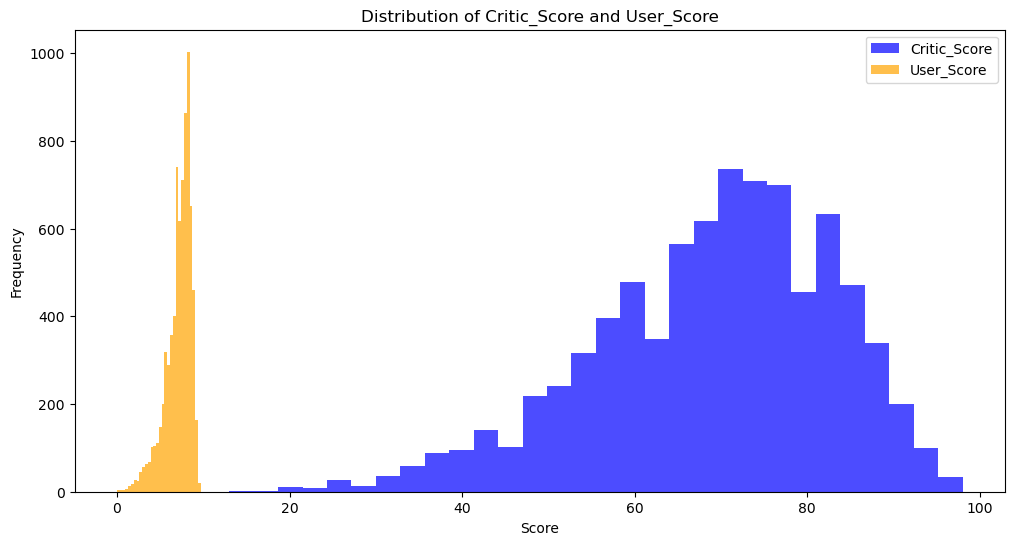

In [16]:
# Visualize the distribution of Critic_Score and User_Score to decide how to fill in the missing values
plt.figure(figsize=(12, 6))
plt.hist(
    df["Critic_Score"].dropna(), bins=30, color="blue", alpha=0.7, label="Critic_Score"
)
plt.hist(
    pd.to_numeric(df["User_Score"], errors="coerce").dropna(),
    bins=30,
    color="orange",
    alpha=0.7,
    label="User_Score",
)
plt.title("Distribution of Critic_Score and User_Score")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Based on the distribution of data, using the median would be a good choice. 

In [18]:
# Impute missing `Critic_Score` and `User_Score` with the median
df["Critic_Score"] = df["Critic_Score"].fillna(df["Critic_Score"].median())
df["User_Score"] = pd.to_numeric(
    df["User_Score"], errors="coerce"
)  # Convert "tbd" to NaN
df["User_Score"] = df["User_Score"].fillna(df["User_Score"].median())

# Handle categorical `Rating` by filling with the mode
df["Rating"] = df["Rating"].fillna(df["Rating"].mode()[0])

# Verify changes in the dataset
print("\nDataset info after handling missing values and dropping rows:")
df.info()


Dataset info after handling missing values and dropping rows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     16719 non-null  float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       16719 non-null  float64
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           16719 non-null  object 


In [19]:
# Drop all rows with any missing values
df.dropna(inplace=True)

# Verify the dataset after dropping rows
print("\nDataset info after removing all rows with any missing values:")
df.info()


Dataset info after removing all rows with any missing values:
<class 'pandas.core.frame.DataFrame'>
Index: 6889 entries, 0 to 16709
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6889 non-null   object 
 1   Platform         6889 non-null   object 
 2   Year_of_Release  6889 non-null   float64
 3   Genre            6889 non-null   object 
 4   Publisher        6889 non-null   object 
 5   NA_Sales         6889 non-null   float64
 6   EU_Sales         6889 non-null   float64
 7   JP_Sales         6889 non-null   float64
 8   Other_Sales      6889 non-null   float64
 9   Global_Sales     6889 non-null   float64
 10  Critic_Score     6889 non-null   float64
 11  Critic_Count     6889 non-null   float64
 12  User_Score       6889 non-null   float64
 13  User_Count       6889 non-null   float64
 14  Developer        6889 non-null   object 
 15  Rating           6889 non-null   object 
dtypes

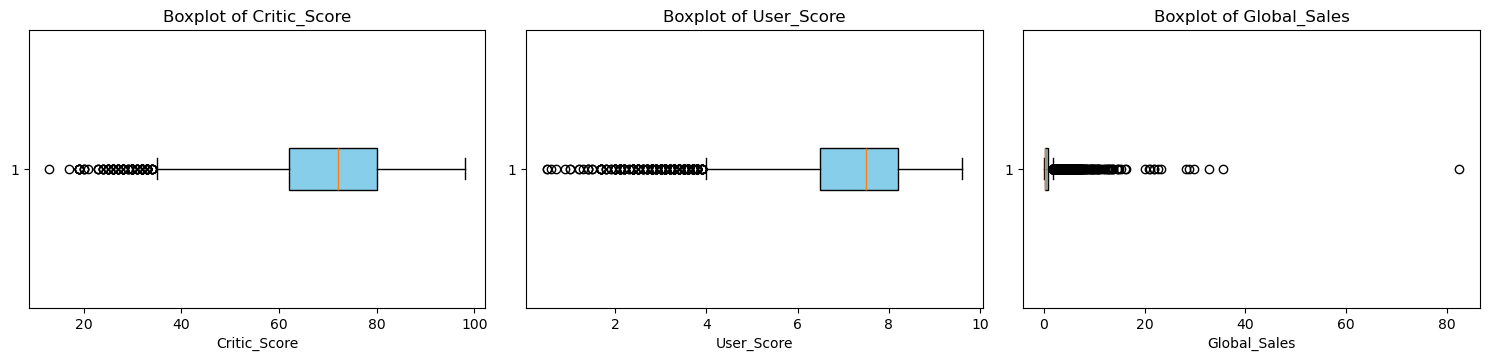

(6889, 16)

In [20]:
# List of numerical columns to check for outliers
numerical_columns = ["Critic_Score", "User_Score", "Global_Sales"]

# Generate boxplots for each numerical column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, start=1):
    if col in df.columns:
        plt.subplot(3, 3, i)  # Create subplots (3 rows x 3 columns for 9 plots)
        plt.boxplot(
            df[col].dropna(),
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor="skyblue"),
        )
        plt.title(f"Boxplot of {col}")
        plt.xlabel(col)
plt.tight_layout()
plt.show()
df.shape

In [21]:
# Remove outliers for Global_Sales
df = df[df["Global_Sales"] <= 80]

df.shape

(6888, 16)

# Data Exploration 

In [23]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6888.000000,6888.000000,6888.000000,6888.000000,6888.000000,6888.000000,6888.000000,6888.000000,6888.000000,6888.000000
mean,2007.481562,0.385190,0.230482,0.063375,0.080839,0.760070,70.267567,28.849013,7.185467,174.422474
std,4.237224,0.827529,0.590509,0.283079,0.249092,1.689226,13.856416,19.195822,1.438866,585.111089
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.500000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,6.500000,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,24.000000,7.500000,27.000000
75%,2011.000000,0.390000,0.210000,0.010000,0.070000,0.750000,80.000000,39.000000,8.200000,89.000000
max,2016.000000,15.680000,12.760000,6.500000,10.570000,35.520000,98.000000,113.000000,9.600000,10665.000000


## Categorical Data

In [25]:
categorical_columns = ["Platform", "Genre", "Publisher", "Developer", "Rating"]

for col in categorical_columns:
    print(f"Value counts for {col}:\n")
    print(df[col].value_counts())

Value counts for Platform:

Platform
PS2     1140
X360     860
PS3      774
PC       686
XB       565
Wii      479
DS       465
PSP      390
GC       348
PS4      249
GBA      237
XOne     165
3DS      156
PS       153
PSV      118
WiiU      89
DC        14
Name: count, dtype: int64
Value counts for Genre:

Genre
Action          1643
Sports           948
Shooter          868
Role-Playing     715
Racing           586
Platform         403
Misc             386
Fighting         379
Simulation       302
Strategy         277
Adventure        263
Puzzle           118
Name: count, dtype: int64
Value counts for Publisher:

Publisher
Electronic Arts                944
Ubisoft                        498
Activision                     492
Sony Computer Entertainment    316
THQ                            307
                              ... 
NDA Productions                  1
Moss                             1
Crytek                           1
Funsta                           1
NewKidCo          

Based on the frequency, there are a lot of publishers and developers so we will frequency encode developer and publisher and one hot encode the rest of the categorical comumns

In [27]:
# Frequency encode 'Publisher' and 'Developer'
print(df.columns)

# Create a copy of the original DataFrame to avoid modifying it
encoded_df = df.copy()

# Frequency encode 'Publisher' and 'Developer'
for col in ["Publisher", "Developer"]:
    freq = encoded_df[col].value_counts()  # Get frequency counts
    encoded_df[col + "_freq"] = encoded_df[col].map(freq)  # Map the counts to a new column

# One-hot encode 'Platform', 'Genre', and 'Rating'
one_hot_encoded_df = pd.get_dummies(encoded_df, columns=["Platform", "Genre", "Rating"], drop_first=False)

# Drop the original 'Publisher' and 'Developer' columns
final_encoded_df = one_hot_encoded_df.drop(columns=["Publisher", "Developer"])

# Save as a separate DataFrame if needed
separate_df = final_encoded_df.copy()

separate_df.head(10)

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')


,Name,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,...,Genre_Simulation,Genre_Sports,Genre_Strategy,Rating_AO,Rating_E,Rating_E10+,Rating_K-A,Rating_M,Rating_RP,Rating_T
2,Mario Kart Wii,2008.0,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,...,False,False,False,False,True,False,False,False,False,False
3,Wii Sports Resort,2009.0,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,...,False,True,False,False,True,False,False,False,False,False
6,New Super Mario Bros.,2006.0,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,...,False,False,False,False,True,False,False,False,False,False
7,Wii Play,2006.0,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,...,False,False,False,False,True,False,False,False,False,False
8,New Super Mario Bros. Wii,2009.0,14.44,6.94,4.70,2.24,28.32,87.0,80.0,8.4,...,False,False,False,False,True,False,False,False,False,False
11,Mario Kart DS,2005.0,9.71,7.47,4.13,1.90,23.21,91.0,64.0,8.6,...,False,False,False,False,True,False,False,False,False,False
13,Wii Fit,2007.0,8.92,8.03,3.60,2.15,22.70,80.0,63.0,7.7,...,False,True,False,False,True,False,False,False,False,False
14,Kinect Adventures!,2010.0,15.00,4.89,0.24,1.69,21.81,61.0,45.0,6.3,...,False,False,False,False,True,False,False,False,False,False
15,Wii Fit Plus,2009.0,9.01,8.49,2.53,1.77,21.79,80.0,33.0,7.4,...,False,True,False,False,True,False,False,False,False,False
16,Grand Theft Auto V,2013.0,7.02,9.09,0.98,3.96,21.04,97.0,50.0,8.2,...,False,False,False,False,False,False,False,True,False,False


## Numerical Data

We are using a correlation heatmap to see how well the features in the data compare to our target value of global sales

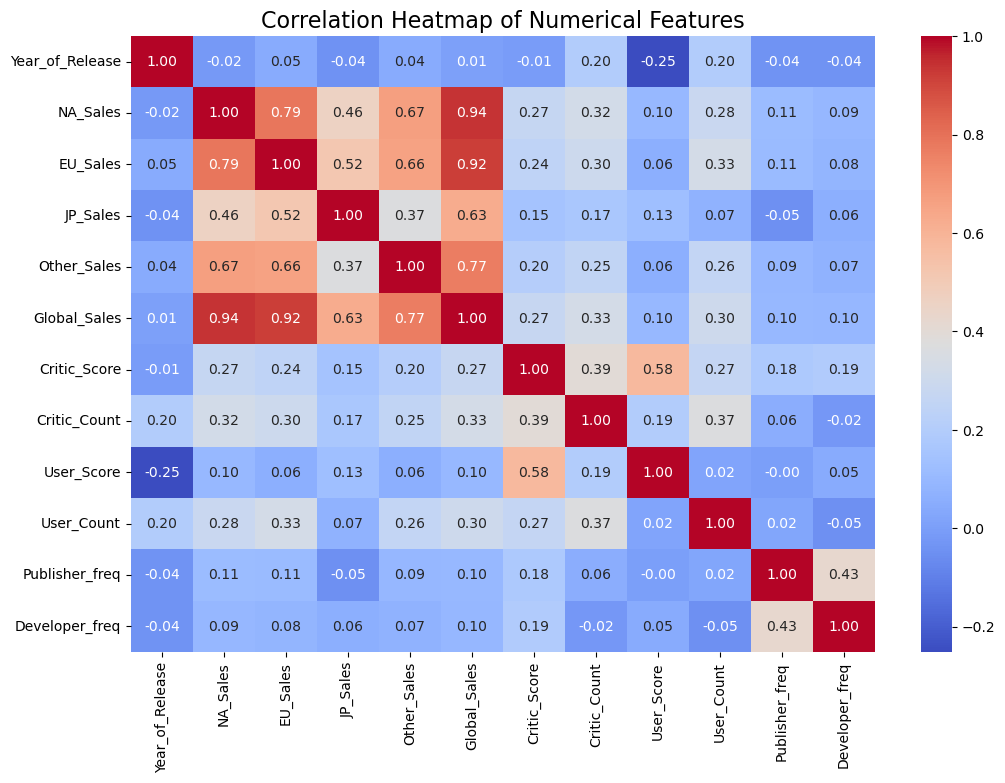

In [30]:
# Select only numerical columns
numerical_data = separate_df.select_dtypes(include=["float64", "int64"])

# Compute correlation matrix
cor = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    cor,
    xticklabels=cor.columns,
    yticklabels=cor.columns,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.show()

- We can see that year of release has almost no correlation (0.01) to global sales
- Looking at user score and critic score, critic score (0.27) has a higher correlation to global sales than user score (0.10)

In [32]:
# lower_quartile_critic_count = df["Critic_Count"].describe()["25%"]
# lower_quartile_user_count = df["User_Count"].describe()["25%"]

# df = df[df["Critic_Count"] >= lower_quartile_critic_count]
# df = df[df["User_Count"] >= lower_quartile_user_count]

# print(df.shape)

In [33]:
# print('df["Platform"].unique():', df["Platform"].unique())
# print('df["Genre"].unique():', df["Genre"].unique())
# print('df["Publisher"].unique():', df["Publisher"].unique().__len__())
# print('df["Developer"].unique():', df["Developer"].unique())
# print('df["Rating"].unique():', df["Rating"].unique())

# # df = pd.get_dummies(df, columns=["Platform", "Genre", "Rating"])
# # df.head()
#
# # rating AO - 1
# # rating K-A - 1

## Bivariate Analysis

### Comparing Platform's to their average Global Sales

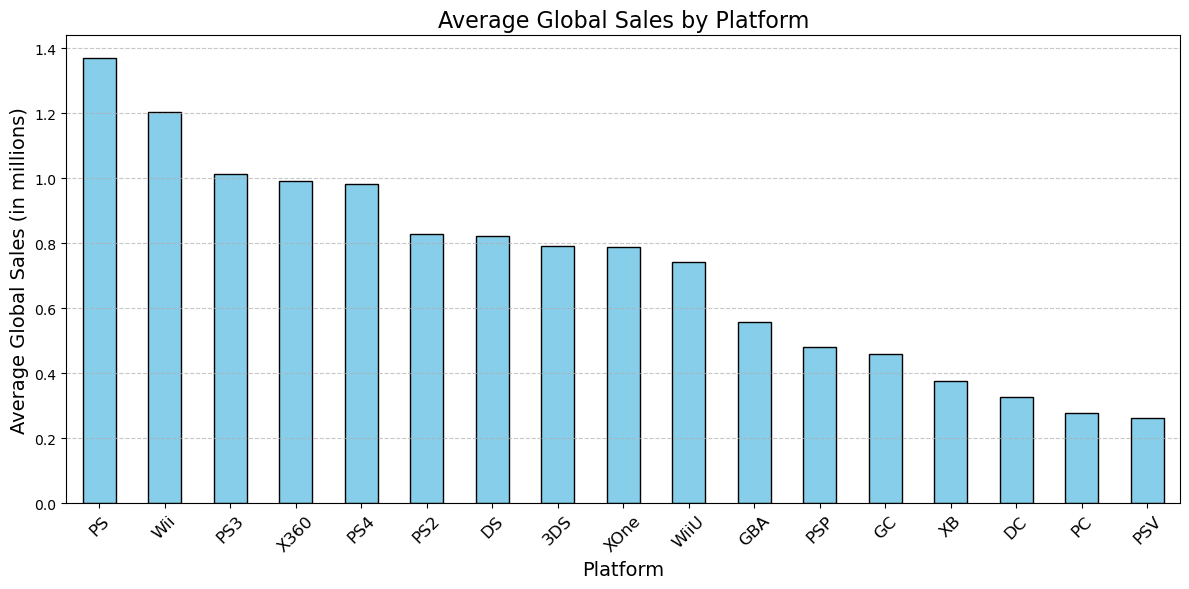

In [36]:
# Step 1: Group by the original 'Platform' column and calculate averages
platform_averages = df.groupby("Platform")["Global_Sales"].mean().sort_values(ascending=False)

# Step 2: Plot the bar chart for average global sales
plt.figure(figsize=(12, 6))
platform_averages.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Global Sales by Platform", fontsize=16)
plt.xlabel("Platform", fontsize=14)
plt.ylabel("Average Global Sales (in millions)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


From looking at the graph, it seems the Play Station (PS) contributed the most to the global sales in the data with around 1.3 Million

### Comparing Publishers to average Global Sales

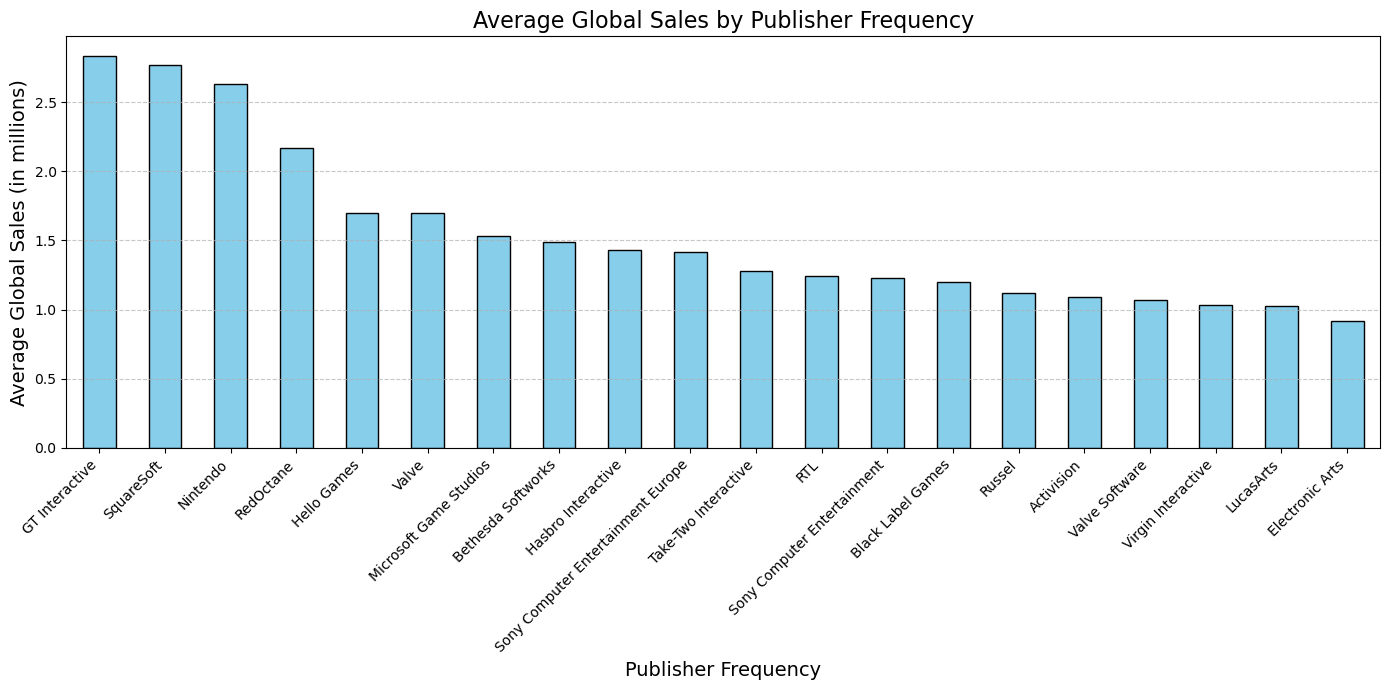

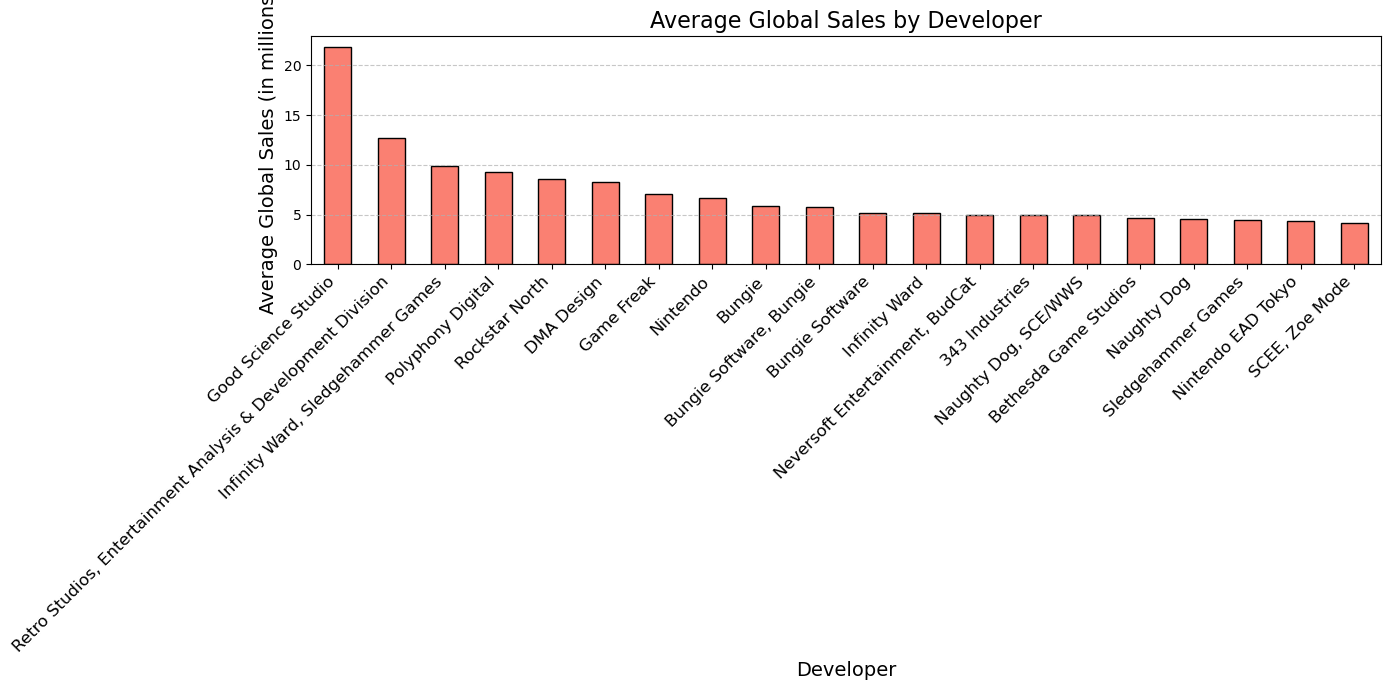

In [64]:
# Step 1: Group by 'Publisher_freq' and calculate average global sales
publisher_avg_sales = df.groupby("Publisher")["Global_Sales"].mean().sort_values(ascending=False)

# Step 2: Plot the bar chart for publisher frequencies
plt.figure(figsize=(14, 7))
publisher_avg_sales.head(20).plot(kind="bar", color="skyblue", edgecolor="black")  # Limit to top 20 for readability
plt.title("Average Global Sales by Publisher Frequency", fontsize=16)
plt.xlabel("Publisher Frequency", fontsize=14)
plt.ylabel("Average Global Sales (in millions)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Adjust figure size and rotate x-axis labels for readability
plt.figure(figsize=(14, 7))
df.groupby("Developer")["Global_Sales"].mean().sort_values(ascending=False).head(20).plot(
    kind="bar", color="salmon", edgecolor="black"
)
plt.title("Average Global Sales by Developer", fontsize=16)
plt.xlabel("Developer", fontsize=14)
plt.ylabel("Average Global Sales (in millions)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotate labels and align them
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()


- Looking at the top 20 publishers in the dataset, GT Interactive and Squaresoft contritubute the most to global sales
- Looking at the top 20 developers in the dataset, Good Science Studio has the highest average global sales and contributes the most to the dataset